In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

harris_p1 = pd.read_csv('data/Option 1/HarrisPartI.csv')
harris_p2 = pd.read_csv('data/Option 1/HarrisPartII.csv')
harris_p3 = pd.read_csv('data/Option 1/HarrisPartIII.csv')
vandenberg = pd.read_csv('data/Option 1/vandenBerg_table2.csv')
krause = pd.read_csv('data/Option 1/Krause21.csv')


# making Krause mergeable
def obj2id(s):
    """ Convert Krause 'Object' string to Harris format.

    Args:
        s (str): Object string from Krause
    """
    
    specifics = ('Ruprecht106', 'Terzan7', 'Palomar12')
    mapping = ('Rup 106', 'Terzan 7', 'Pal 12')
    
    if s[0:3] == "NGC":
        return "NGC " + s[3:]
    else:
        for i in range(len(specifics)):
            if s == specifics[i]:
                return mapping[i]
        return None
    
krause['ID'] = krause['Object'].apply(obj2id)
krause.head()

,Class,Object,AltName,Mstar,rh,C5,Age,FeH,ID
0,GC,NGC104,47Tuc,6.46,7.10,0.92,12.80,-0.76,NGC 104
1,GC,NGC288,Melotte3,0.46,9.80,0.05,12.20,-1.32,NGC 288
2,GC,NGC362,Dunlop62,2.50,3.50,0.72,10.00,-1.26,NGC 362
3,GC,NGC1261,Caldwell87,3.41,5.50,0.62,10.24,-1.08,NGC 1261
4,GC,NGC1851,Dunlop508,5.51,3.05,1.81,7.64,-1.13,NGC 1851


### CSV File Information
#### Harris Part I (Identifications and Positional Data)
- 1 ['ID'] Cluster identification number
- 2 ['Name'] Other commonly used cluster name
- 3,4 ['RA'], ['DEC'] Right ascension and declination (epoch J2000)
- 5,6 ['L'], ['B'] Galactic longitude and latitude (degrees)
- 7 ['R_sun'] Distance from Sun (kiloparsecs)
- 8 ['R_gc'] Distance from Galactic center (kpc), assuming R_0=8.0 kpc
- 9-11 ['X'], ['Y'], ['Z'] Galactic distance components X,Y,Z in kiloparsecs, in a Sun-centered coordinate system; X points toward Galactic center, Y in direction of Galactic rotation, Z toward North Galactic Pole

#### Harris Part II (Metallicity and Photometry)

1. ['ID'] - Cluster identification  
2. ['Fe_H'] - Metallicity [Fe/H]  
3. ['wt'] - Weight of mean metallicity; essentially the number of independent [Fe/H] measurements averaged together  
4. ['E_BV'] - Foreground reddening (E(B-V))  
5. ['V_HB'] - V magnitude level of the horizontal branch (or RR Lyraes)  
6. ['m_MV'] - Apparent visual distance modulus (m-M)V  
7. ['V_t'] - Integrated V magnitude of the cluster  
8. ['M_V_t'] - Absolute visual magnitude (cluster luminosity), M_V,t = V_t - (m-M)V  
9. ['U_B'] - Integrated color index U-B (uncorrected for reddening)  
10. ['B_V'] - Integrated color index B-V (uncorrected for reddening)  
11. ['V_R'] - Integrated color index V-R (uncorrected for reddening)  
12. ['V_I'] - Integrated color index V-I (uncorrected for reddening)  
13. ['spt'] - Spectral type of the integrated cluster light  
14. ['ellip'] - Projected ellipticity of isophotes, e = 1-(b/a)  


#### Harris Part III (Velocities and Structural Parameters)

1. ['ID'] - Cluster identification  
2. ['v_r'] - Heliocentric radial velocity (km/s)  
3. ['v_r_e'] - Observational (internal) uncertainty in radial velocity  
4. ['v_LSR'] - Radial velocity relative to Solar neighborhood LSR  
5. ['sig_v'] - Central velocity dispersion sig_v (km/s)  
6. ['sig_v_e'] - Observational (internal) uncertainty in velocity dispersion  
7. ['c'] - King-model central concentration, c = log(r_t/r_c); a 'c' denotes a core-collapsed cluster  
8. ['r_c'] - Core radius in arcmin  
9. ['r_h'] - Half-light radius in arcmin  
10. ['mu_V'] - Central surface brightness, V magnitudes per square arcsecond  
11. ['rho_0'] - Central luminosity density, log_10(Solar luminosities per cubic parsec)  
12. ['lg_tc'] - Core relaxation time t(r_c), in log_10(years)  
13. ['lg_th'] - Median relaxation time t(r_h), in log_10(years) 

#### Vandenburg

1. ['#NGC'] - NGC cluster identification number  
2. ['Name'] - Other commonly used cluster name  
3. ['FeH'] - Metallicity [Fe/H]  
4. ['Age'] - Age of the cluster  
5. ['Age_err'] - Age uncertainty  
6. ['Method'] - Method used for determining age  
7. ['Figs'] - Figures referenced in the study  
8. ['Range'] - Range of the measurements  
9. ['HBtype'] - Horizontal branch type  
10. ['R_G'] - Distance from Galactic center (kpc)  
11. ['M_V'] - Absolute visual magnitude  
12. ['v_e0'] - Central escape velocity  
13. ['log_sigma_0'] - Central logarithmic velocity dispersion  


<p style=
    "display: flex;
    flex-direction: column; 
    align-items: center;
    text-align: center;"
>
    <img src="images/vandenberg_variables.png" alt="vandenberg_variables" width="600px"/>
    <em>
        <br/>
        Vandenberg variables as shown in https://arxiv.org/pdf/1308.2257
    </em>
</p>

#### Krause

1. ['Class'] - Classification or category of the object  
2. ['Object'] - Object name or identification number  
3. ['AltName'] - Alternative name or designation for the object  
4. ['Mstar'] - Stellar mass (Mstar) of the object  
5. ['rh'] - Half-light radius (rh) of the object  
6. ['C5'] - Compactness parameter (C5) of the object  
7. ['Age'] - Age of the object in billions of years  
8. ['FeH'] - Metallicity of the object, typically measured as [Fe/H]  

## Tangential Velocity vs. Metallicity

-22.525849135135132 0.00860472
-0.9789035 0.00250608
-6.613393005319149 -0.0525225
-4.838435435359116 -0.04209372200000001
-8.05194601506024 -0.29314853
-1.7785465340425528 -0.05610108000000001
-1.277412367721519 -0.01999727
-28.543626659459463 -0.13871447999999997
-2.0055025 -0.04781920000000001
-2.662202902941177 0.010335558000000002
-14.91422637142857 -0.05745739999999999
-11.564625536956521 0.095597936
-1.8025011797752808 -0.00979
-9.9552006 0.08289215999999998
-20.656889098876405 -0.036424318
-2.7725786788343556 -0.032298939000000006
-7.306532074324323 -0.015848209999999998
-16.17669386451613 -0.012830776
-18.903621967391306 0.0167141
-32.163547575 -0.025560528
-34.09004279210526 -0.0015451559999999998
-1.6510091285714288 -0.04047679999999999
-5.09236148220339 -0.004880421
-27.238872216666667 -0.0009165600000000001
-15.964514244444445 -0.008843094
-9.143394495454544 0.001316601
-23.510440728571428 0.1589742
-4.234994733333334 0.0013786199999999999
-8.554845191304349 -0.005292576
-

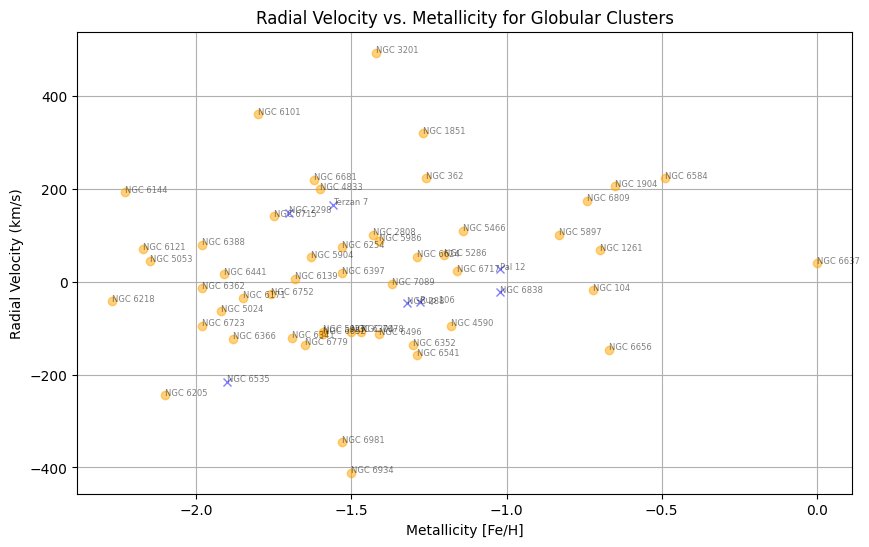

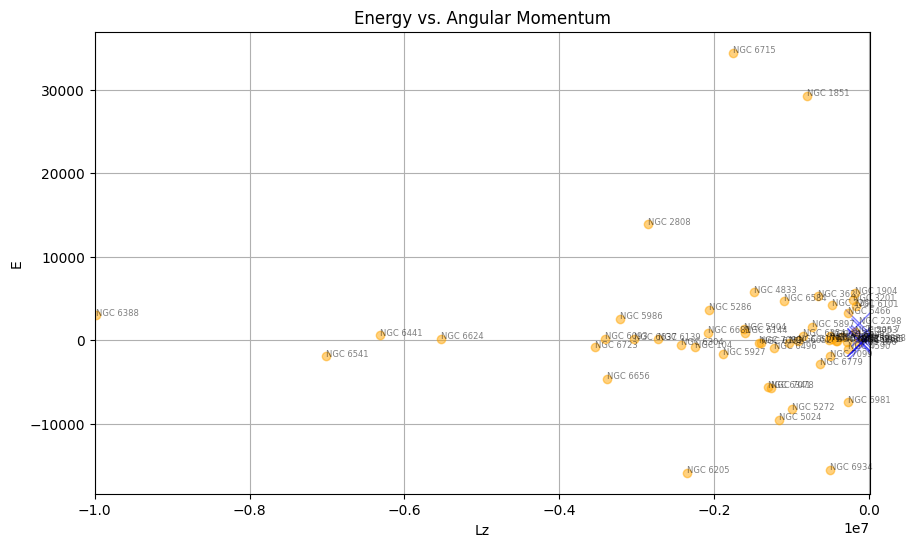

,Class,Object,AltName,Mstar,rh,C5,Age,FeH,ID,Name,...,r_c,r_h,mu_V,rho_0,lg_tc,lg_th,E,Lz,[Fe/H],Classification
0,GC,NGC104,47Tuc,6.46,7.10,0.92,12.80,-0.76,NGC 104,47 Tuc,...,0.36,3.17,14.38,4.88,7.84,9.55,-2.252585e+06,-860.4720,-0.72,accreted
1,GC,NGC288,Melotte3,0.46,9.80,0.05,12.20,-1.32,NGC 288,NaN,...,1.35,2.23,20.05,1.78,8.99,9.32,-9.789035e+04,-250.6080,-1.32,in-situ
2,GC,NGC362,Dunlop62,2.50,3.50,0.72,10.00,-1.26,NGC 362,NaN,...,0.18,0.82,14.80,4.74,7.76,8.93,-6.613393e+05,5252.2500,-1.26,accreted
3,GC,NGC1261,Caldwell87,3.41,5.50,0.62,10.24,-1.08,NGC 1261,NaN,...,0.35,0.68,17.73,2.99,8.59,9.12,-4.838435e+05,4209.3722,-0.70,accreted
4,GC,NGC1851,Dunlop508,5.51,3.05,1.81,7.64,-1.13,NGC 1851,NaN,...,0.09,0.51,14.25,5.09,7.43,8.82,-8.051946e+05,29314.8530,-1.27,accreted


In [114]:
def calculate_orbital_properties(harris_p1, harris_p3):
    """
    Compute total energy E and z-component of angular momentum Lz for each globular cluster.

    Args:
    - harris_p1: DataFrame containing positional data and distance components.
    - harris_p3: DataFrame containing velocity data.

    Returns:
    - clusters_df: DataFrame with calculated E and Lz properties for each cluster.
    """
    # Merge the positional and velocity data based on cluster ID
    clusters_df = pd.merge(harris_p1, harris_p3, on='ID')
    clusters_df = pd.merge(krause, clusters_df, on='ID')

    # Constants (assuming certain values for the Galaxy)
    G = 4.30091e-6  # Gravitational constant in kpc (km/s)^2 / Msun
    M_gal = 6e11    # Approximate mass of the Milky Way in solar masses

    # Calculate total energy assumed kinetic component (assumed kinetic component mostly in radial, which is bad)
    clusters_df['E'] = -G * M_gal * clusters_df['Mstar'] / clusters_df['R_gc'] + 0.5 * clusters_df['v_r']**2
    # clusters_df['E'] = -G * M_gal * clusters_df['Mstar'] / clusters_df['R_gc']

    # Calculate z-component of angular momentum
    clusters_df['Lz'] = clusters_df['Mstar'] * clusters_df['R_gc'] * clusters_df['v_r'] # Simplified formula for Lz, assuming unit (solar) mass

    return clusters_df

def plot_radial_velocity_vs_metallicity(clusters_df):
    """
    Plot radial velocity vs. metallicity for globular clusters.

    Args:
    - clusters_df: DataFrame with cluster information including metallicities and tangential velocities.
    """
    metallicities = clusters_df['[Fe/H]']
    v_r = clusters_df['v_r'].astype(float)
    classification = clusters_df['Classification']
    ids = clusters_df['ID']

    plt.figure(figsize=(10, 6))
    # plt.scatter(metallicities, v_r, color='purple', alpha=0.7)
    
    for i in range(len(metallicities)):
        if classification[i] == 'in-situ':
            plt.plot(
            metallicities[i],
            v_r[i],
            'x',
            alpha=0.5,
            label='in-situ',
            color='blue'
            )
        else:
            plt.plot(
            metallicities[i],
            v_r[i],
            'o',
            alpha=0.5,
            label='in-situ',
            color='orange'
            )
        plt.annotate(ids[i], (metallicities[i], v_r[i]), fontsize=6, alpha=0.5)
        
        
            

    plt.title("Radial Velocity vs. Metallicity for Globular Clusters")
    plt.xlabel("Metallicity [Fe/H]")
    plt.ylabel("Radial Velocity (km/s)")
    plt.grid(True)
    plt.show()
    
def plot_lz_E(clusters_df):
    """
    Plot radial velocity vs. metallicity for globular clusters.

    Args:
    - clusters_df: DataFrame with cluster information including metallicities and tangential velocities.
    """
    Lz = clusters_df['Lz']
    E = clusters_df['E']
    classification = clusters_df['Classification']
    ids = clusters_df['ID']

    plt.figure(figsize=(10, 6))
    # plt.scatter(metallicities, v_r, color='purple', alpha=0.7)
    
    for i in range(len(E)):
        if classification[i] == 'in-situ':
            plt.plot(
            E[i],
            Lz[i],
            'x',
            alpha=0.5,
            label='in-situ',
            color='blue',
            markersize=20
            )
        else:
            plt.plot(
            E[i],
            Lz[i],
            'o',
            alpha=0.5,
            label='in-situ',
            color='orange'
            )
        plt.annotate(ids[i], (E[i], Lz[i]), fontsize=6, alpha=0.5)
        
        
            

    plt.title("Energy vs. Angular Momentum")
    plt.xlabel("Lz")
    plt.ylabel("E")
    plt.grid(True)
    
    plt.xlim(-1e7, 1e4)
    
    plt.show()

def classify_clusters_by_ELz(clusters_df):
    """
    Classify globular clusters as in-situ or accreted based on E-Lz boundary.

    Args:
    - clusters_df: DataFrame containing computed E and Lz values.

    Returns:
    - clusters_df: Updated DataFrame with a new column 'Classification' indicating in-situ or accreted.
    """
    # Define E-Lz boundaries based on the https://arxiv.org/pdf/2309.15902 methodology
    def is_in_situ(E, Lz):
        E = E/(10**5)
        Lz = -Lz/(10**5)
        print(E, Lz)
        if Lz < (-0.58):
            return E < -1.3
        elif -0.58 <= Lz <= 0.58:
            return E < (-1.4 + 0.3 * Lz**2)
        else:
            return E < (-1.325 + 0.075 * Lz**2) 

    clusters_df['Classification'] = clusters_df.apply(lambda row: 'in-situ' if not is_in_situ(row['E'], row['Lz']) else 'accreted', axis=1)
    
    return clusters_df


clusters_df = calculate_orbital_properties(harris_p1, harris_p3)

# join with metallicities
harris_p2['[Fe/H]'] = pd.to_numeric(harris_p2['[Fe/H]'], errors='coerce')
clusters_df['[Fe/H]'] = harris_p2['[Fe/H]']

classify_clusters_by_ELz(clusters_df)
print(clusters_df.columns)

plot_radial_velocity_vs_metallicity(clusters_df)
plot_lz_E(clusters_df)

clusters_df.head()


## Velocity Dispersion vs Radial Velocity

62            ID    Name           RA          DEC       L      B  R_Sun  R_gc  \
0     NGC 104  47 Tuc  00:24:05.67  -72:04:52.6  305.89 -44.89    4.5   7.4   
1     NGC 288     NaN  00:52:45.24  -26:34:57.4  152.30 -89.38    8.9  12.0   
2     NGC 362     NaN  01:03:14.26  -70:50:55.6  301.53 -46.25    8.6   9.4   
9    NGC 1851     NaN  05:14:06.76  -40:02:47.6  244.51 -35.03   12.1  16.6   
10   NGC 1904    M 79  05:24:11.09  -24:31:29.0  227.23 -29.35   12.9  18.8   
..        ...     ...          ...          ...     ...    ...    ...   ...   
151  NGC 7078    M 15  21:29:58.33  +12:10:01.2   65.01 -27.31   10.4  10.4   
152  NGC 7089     M 2  21:33:27.02  -00:49:23.7   53.37 -35.77   11.5  10.4   
153  NGC 7099    M 30  21:40:22.12  -23:10:47.5   27.18 -46.84    8.1   7.1   
155    Pal 13     NaN  23:06:44.44  +12:46:19.2   87.10 -42.70   26.0  26.9   
156  NGC 7492     NaN  23:08:26.63  -15:36:41.4   53.39 -63.48   26.3  25.3   

       X     Y  ...  v_LSR  sig_v  sig_v_e     c

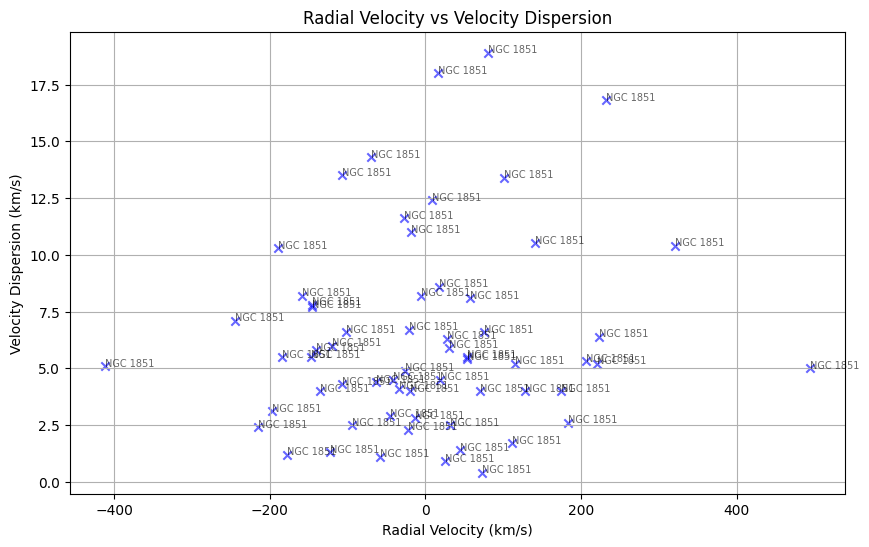

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Harris Part I and III data
harris_part1 = pd.read_csv('data/Option 1/HarrisPartI.csv')
harris_part3 = pd.read_csv('data/Option 1/HarrisPartIII.csv')

# Merge the relevant data based on the 'ID' column (Cluster identification)
merged_data = pd.merge(harris_part1, harris_part3, on="ID")

# Use radial velocity (v_r) from Part III
V_r = merged_data['v_r']

# Estimate tangential velocity using velocity dispersion (sig_v) as a proxy
V_t = merged_data['sig_v']

# Remove any rows with missing or NaN values for velocity dispersion
valid_data = merged_data[~merged_data['sig_v'].isna()]
cluster_ids = valid_data['ID']

print(len(valid_data), valid_data)

# Plotting Radial Action (v_r) vs Tangential Velocity (using sig_v as a proxy)
plt.figure(figsize=(10, 6))
plt.scatter(valid_data['v_r'], valid_data['sig_v'], marker='x', c='b', label='Globular Clusters', alpha=0.6)

for i, row in valid_data.iterrows():
    plt.annotate(id, (row['v_r'], row['sig_v']), fontsize=7, alpha=0.6)

plt.title('Radial Velocity vs Velocity Dispersion')
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Velocity Dispersion (km/s)')
plt.grid(True)
# plt.legend()
plt.show()
